# Augmented Reality App

# Imports and setup

In [1]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [3]:
# Get all possible color names from matplotlib
COLORS = list(plt.cm.colors.cnames.keys())

# Load Marker and Source images

Marker reference image:

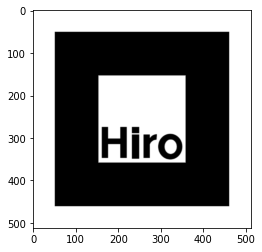

In [4]:
reference_image = cv2.imread('../img/hiro.png', 0)

plt.imshow(reference_image, cmap='gray')
plt.show()

Source image that contains the marker:

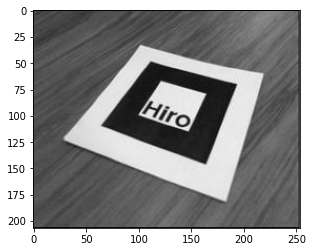

In [45]:
image = cv2.imread('../img/sourceImg_hiro.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.show()

Images are converted to gray scale for better processing.

# Square detection

Convert the image to grayscale

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Apply GaussianBlur to reduce noise and help Canny edge detection

In [7]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

Apply Canny edge detection

In [41]:
edges = cv2.Canny(blurred, 75, 175)  # Parameters tuned according to the source image 

"Number of edges detected:", len(edges)

('Number of edges detected:', 207)

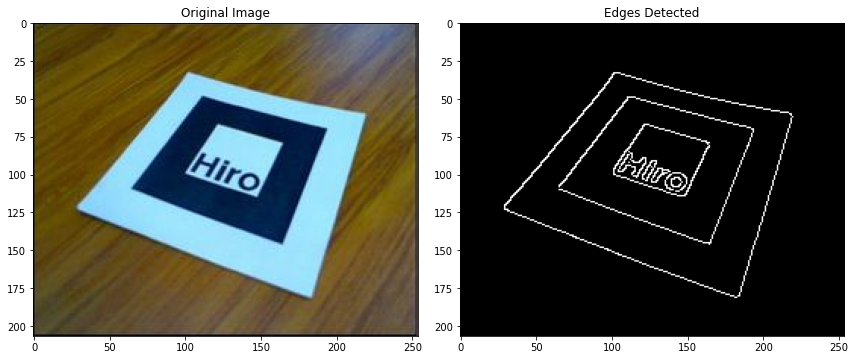

In [46]:
# Create a larger figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')

# Plot the edges
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges Detected')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Find lines using HoughLinesP

In [47]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

"Number of lines found:", len(lines)

('Number of lines found:', 9)

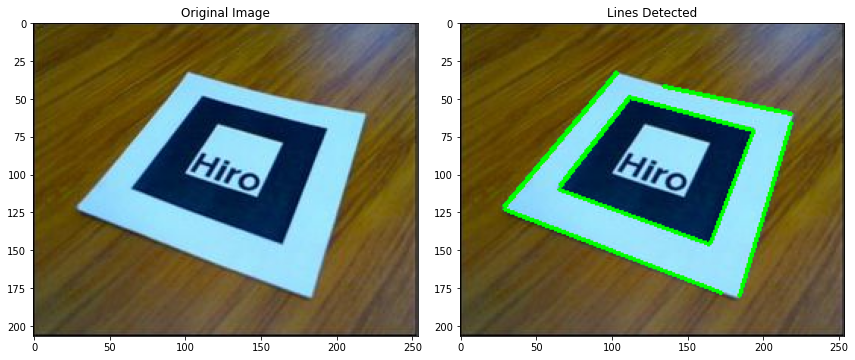

In [48]:
# Create a larger figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')

# Create a copy of the image for drawing lines
line_image = np.copy(image)

# Draw lines on the copy
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Plot the image with lines
axes[1].imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Lines Detected')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Find intersections of lines

In [61]:
def find_intersections(lines, image_shape, border_threshold=10, min_intersection_distance=5):
    intersections = []

    def distance(pt1, pt2):
        return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            x1, y1, x2, y2 = lines[i][0]
            x3, y3, x4, y4 = lines[j][0]

            # Check if the lines are not too parallel
            angle_threshold = np.radians(10)
            if np.abs(np.arctan2(y2 - y1, x2 - x1) - np.arctan2(y4 - y3, x4 - x3)) > angle_threshold:
                # Calculate intersection point
                det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                if det != 0:
                    intersection_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
                    intersection_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det

                    # Check if the intersection point is within the image bounds
                    if (
                        border_threshold <= intersection_x < image_shape[1] - border_threshold and
                        border_threshold <= intersection_y < image_shape[0] - border_threshold
                    ):
                        new_intersection = (int(intersection_x), int(intersection_y))

                        # Check the minimum distance to existing intersections
                        if all(distance(new_intersection, intersection) >= min_intersection_distance for intersection in intersections):
                            intersections.append(new_intersection)
    return intersections

In [62]:
intersections = find_intersections(lines, image.shape)

"Number of intersections found:", len(intersections)

('Number of intersections found:', 16)

Plot the intersections

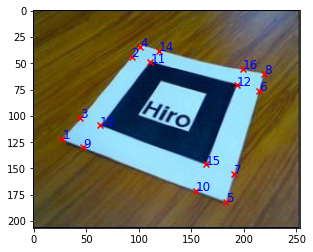

In [66]:
# Plot the original image with intersections
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot intersections with IDs
if intersections:
    intersections_array = np.array(intersections)
    plt.scatter(intersections_array[:, 0], intersections_array[:, 1], c='red', marker='x')
    for i, (x, y) in enumerate(intersections):
        plt.text(x, y, f'{i+1}', color='blue', fontsize=12)
plt.show()

### TRYING ON THIS NOW

Note to self: I don't know why this is not working. Now the plots don't work anymore. Before, it detected 53 squares, but none of them were correct??? 

Next step: think about the whole pipeline. Draw out the flow chart. Which steps are necessary, and which aren't? Where is the problem? Also, organize and clean-up the code.

Consideration: checking for parallel lines is probably a bad idea due to camera distortion. How can we consider this in our calculations? Get a set of 4 intersections and then check all 4 sets of markers that are inside the area defined by the first set?

In [ ]:
def is_second_rect_within_first(rectangle1, rectangle2):
    # Check if all four corners of the second rectangle are within the first rectangle
    for point in rectangle2:
        if not is_point_within_rect(point, rectangle1):
            return False
    return True

def is_point_within_rect(point, rectangle):
    x, y = point

    # Check if the point is within the boundaries of the rectangle
    return (
        rectangle[0][0] <= x <= rectangle[2][0] and
        rectangle[0][1] <= y <= rectangle[2][1]
    )


In [ ]:
def find_rectangles(intersections):
    pass

In [69]:
def find_rectangles(intersections):
# Filter out pairs of rectangles with a matching center
    rectangles = []
    for i in range(len(intersections)):
        for j in range(i + 1, len(intersections)):
            center1 = intersections[i]
            center2 = intersections[j]

            # Assuming you have a function 'is_second_rect_within_first' that checks containment
            if is_second_rect_within_first(center1, center2, rectangle_width, rectangle_height):
                rectangles.append((center1, center2))

    # Plot the original image with intersections
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Plot rectangles
    for i, (center1, center2) in enumerate(rectangles):
        plt.scatter(center1[0], center1[1], c='red', marker='x')
        plt.scatter(center2[0], center2[1], c='blue', marker='x')
        plt.plot([center1[0], center2[0]], [center1[1], center2[1]], 'g-')  # Connect centers with a line
        plt.text(center1[0], center1[1], f'{i+1}', color='red', fontsize=12)
        plt.text(center2[0], center2[1], f'{i+1}', color='blue', fontsize=12)

    plt.show()
find_rectangles(intersections)

NameError: name 'is_second_rect_within_first' is not defined

In [67]:
# Latest try
def are_lines_parallel(line1, line2, angle_threshold=np.radians(10)):
    # Check if two lines are parallel based on their angles
    angle1 = np.arctan2(line1[3] - line1[1], line1[2] - line1[0])
    angle2 = np.arctan2(line2[3] - line2[1], line2[2] - line2[0])

    return np.abs(angle1 - angle2) < angle_threshold

import numpy as np

def are_lines_intersecting(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Calculate the slopes of the lines
    slope1 = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else np.inf
    slope2 = (y4 - y3) / (x4 - x3) if (x4 - x3) != 0 else np.inf

    # Check if the lines are parallel (no intersection)
    if slope1 == slope2:
        return False

    # Calculate the intersection point
    intersection_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / \
                      ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
    intersection_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / \
                      ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))

    # Check if the intersection point lies within the range of both lines
    if min(x1, x2) <= intersection_x <= max(x1, x2) and \
       min(y1, y2) <= intersection_y <= max(y1, y2) and \
       min(x3, x4) <= intersection_x <= max(x3, x4) and \
       min(y3, y4) <= intersection_y <= max(y3, y4):
        return True

    return False


# def get_lines(square):
#     lines = [
#         np.concatenate((square[0], square[1]), axis=0),
#         np.concatenate((square[0], square[2]), axis=0),
#         np.concatenate((square[0], square[3]), axis=0),
#         np.concatenate((square[1], square[2]), axis=0),
#         np.concatenate((square[1], square[3]), axis=0),
#         np.concatenate((square[2], square[3]), axis=0),
#     ]
#     return lines

def get_lines(square):
    # Sort vertices based on x-coordinates
    sorted_square = sorted(square, key=lambda point: point[0])

    # Determine the order of vertices
    if sorted_square[0][1] < sorted_square[1][1]:
        top_left, bottom_left = sorted_square[0], sorted_square[1]
    else:
        top_left, bottom_left = sorted_square[1], sorted_square[0]

    if sorted_square[2][1] < sorted_square[3][1]:
        top_right, bottom_right = sorted_square[2], sorted_square[3]
    else:
        top_right, bottom_right = sorted_square[3], sorted_square[2]

    # Form lines between adjacent vertices
    lines = [
        np.concatenate((top_left, top_right), axis=0),       # Top side
        np.concatenate((top_right, bottom_right), axis=0),   # Right side
        np.concatenate((bottom_right, bottom_left), axis=0), # Bottom side
        np.concatenate((bottom_left, top_left), axis=0),     # Left side
    ]

    return lines

def assert_is_square(square, height_threshold=50, width_threshold=50):
    parallel_lines = 0
    opposite_vertices = []

    lines = get_lines(square)
    for index1 in range(len(lines)):
        for index2 in range(index1+1, len(lines)):  # Check lines uniquely without repeating
            if are_lines_parallel(lines[index1], lines[index2]) and not are_lines_intersecting(lines[index1], lines[index2]):
                # A rectangle has 2 pairs of parallel lines that do not intersect.
                parallel_lines += 1
                opposite_vertices.append(lines[index1][:2])
                opposite_vertices.append(lines[index2][:2])
    if parallel_lines == 2:
        #  # Check height and width thresholds
        # diagonal_length = np.linalg.norm(opposite_vertices[0] - opposite_vertices[1])
        # height = np.abs(opposite_vertices[0][1] - opposite_vertices[1][1])
        # width = np.abs(opposite_vertices[0][0] - opposite_vertices[1][0])

        # if height >= height_threshold and width >= width_threshold:
        #     return True
        return True

def plot_squares(squares, lines):
    num_plots = len(squares)
    num_plots_per_row = 3
    num_rows = (num_plots + num_plots_per_row - 1) // num_plots_per_row

    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(18, 3*num_rows))

    for i, square in enumerate(squares):
        ax = axes[i // num_plots_per_row, i % num_plots_per_row]

        # Plot image
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Plot the lines
        for idx, line in enumerate(lines[i]):
            ax.plot([line[0], line[2]], [line[1], line[3]], color='green')

        # Plot square vertices
        ax.scatter(square[:, 0], square[:, 1], c='red', marker='x')

        # Plot square center
        center = np.mean(square, axis=0)  # Calculate the center of the square
        ax.scatter(center[0], center[1], c='blue', marker='o')

        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"Square {i + 1}")

    plt.show()


def find_squares(intersections):
    detected_squares = []
    detected_lines = []
    for i in range(len(intersections)):
        for j in range(i+1, len(intersections)):
            for k in range(j+1, len(intersections)):
                for l in range(k+1, len(intersections)):
                    square = np.array([intersections[i], intersections[j], intersections[k], intersections[l]])
                    # squares.append(square)
                    is_square = assert_is_square(square)
                    if is_square: 
                        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                        # for idx, line in enumerate(lines):
                        #     color_id = random.randint(0, len(COLORS)-1)
                        #     plt.plot([line[0], line[2]], [line[1], line[3]], color=COLORS[color_id])
                        # plt.show()
                        # print(square)
                        detected_squares.append(square)
                        detected_lines.append(lines)
    return detected_squares, detected_lines

# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
squares, lines = find_squares(intersections)
print(len(squares))
# plot_squares(squares, lines)
for i, square in enumerate(squares):

    # Plot image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Plot the lines
    for idx, line in enumerate(lines[i]):
        plt.plot([line[0], line[2]], [line[1], line[3]], color='green')

    # Plot square vertices
    plt.scatter(square[:, 0], square[:, 1], c='red', marker='x')

    # Plot square center
    center = np.mean(square, axis=0)  # Calculate the center of the square
    plt.scatter(center[0], center[1], c='blue', marker='o')

plt.show()
# for square in squares:
#     color_id = random.randint(0, len(COLORS)-1)
#     plt.scatter(square[:, 0], square[:, 1], c=COLORS[color_id], marker='x')
    # Annotate each vertex with its ID number
    # for vertex_id, vertex in enumerate(square):
    #     plt.text(vertex[0], vertex[1], str(vertex_id), color=COLORS[random.randint(0, len(COLORS)-1)], fontsize=15)
    # plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio for better visualization
# plt.show()
"Number of squares found:", len(squares)

0


('Number of squares found:', 0)

### ----------------

In [16]:
import numpy as np

def are_lines_parallel(line1, line2, angle_threshold=np.radians(10)):
    # Check if two lines are parallel based on their angles
    angle1 = np.arctan2(line1[3] - line1[1], line1[2] - line1[0])
    angle2 = np.arctan2(line2[3] - line2[1], line2[2] - line2[0])

    return np.abs(angle1 - angle2) < angle_threshold

def find_duplicate_squares(intersections):
    squares = []
    duplicate_squares = []
    centers = []

    debug = 0

    for i in range(len(intersections)):
        for j in range(i+1, len(intersections)):
            for k in range(j+1, len(intersections)):
                for l in range(k+1, len(intersections)):
                    square = np.array([intersections[i], intersections[j], intersections[k], intersections[l]])

                    lines = [
                        np.concatenate((square[0], square[1]), axis=0),
                        np.concatenate((square[0], square[2]), axis=0),
                        np.concatenate((square[0], square[3]), axis=0),
                        np.concatenate((square[1], square[2]), axis=0),
                        np.concatenate((square[1], square[3]), axis=0),
                        np.concatenate((square[2], square[3]), axis=0),
                    ]
                    

                    parallel_lines = 0
                    unique_parallel_lines = set()
                    for index1 in range(6): # 4 intersections create 6 unique lines
                        for index2 in range(index1+1, 6):  # check lines uniquely without repeating
                            if are_lines_parallel(lines[index1], lines[index2]):
                                unique_parallel_lines.add(tuple(lines[index1]))
                                unique_parallel_lines.add(tuple(lines[index2]))
                                parallel_lines += 1


                    if parallel_lines == 2:
                        center = np.mean(square, axis=0)  # Calculate the center of the square
                        squares.append(square)
                        centers.append(center)
                        debug += 1
                        if debug == 1000:
                            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                            for idx, line in enumerate(lines):
                                color_id = random.randint(0, len(COLORS)-1)
                                plt.plot([line[0], line[2]], [line[1], line[3]], color=COLORS[color_id])
                                # Annotate the line with its ID number
                                plt.text(line[0], line[1], str(idx), color=COLORS[color_id], fontsize=15)
                            # for line in lines:
                                # plt.plot([line[0], line[2]], [line[1], line[3]], color=COLORS[random.randint(0, len(COLORS)-1)])
                            # Plot square vertices
                            plt.scatter(square[:, 0], square[:, 1], c='red', marker='x')
                            # Annotate each vertex with its ID number
                            # for vertex_id, vertex in enumerate(square):
                            #     plt.text(vertex[0], vertex[1], str(vertex_id), color=COLORS[random.randint(0, len(COLORS)-1)], fontsize=15)
                            plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio for better visualization
                            plt.show()

                    
                    

                        # # Check if a square with the same center already exists
                        # duplicate = False
                        # for prev_center, prev_square in zip(centers, squares):
                        #     if np.allclose(center, prev_center):
                        #         duplicate_sqr = prev_square
                        #         # Duplicate center!
                        #         duplicate_squares.append(square)
                        #         duplicate_squares.append(duplicate_sqr)
                        #         duplicate = True
                        #         break

                        # if not duplicate:
                        #     squares.append(square)
                        #     centers.append(center)

    return squares

squares = find_duplicate_squares(intersections)
len(squares)

450

In [17]:
# Draw the detected squares on the original image
for square in squares:
    cv2.polylines(image, [square], isClosed=True, color=(0, 255, 0), thickness=1)

# Display the result
cv2.imshow('Square Detector', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Plot detected squares along with intersections

TypeError: list indices must be integers or slices, not tuple

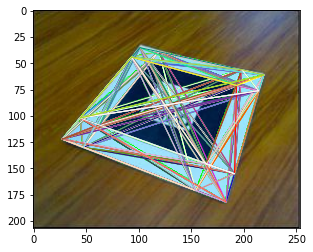

In [18]:
# Plot the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot squares
if squares:
    i = 0
    for square in squares:
        square = np.array(square)
        plt.plot(np.append(square[:, 0], square[0, 0]), np.append(square[:, 1], square[0, 1]), c=COLORS[i], linewidth=1)
        i+=1
        if i >= len(COLORS): break

# Plot intersections
plt.scatter(intersections[:, 0], intersections[:, 1], c='red', marker='x')

# Display the plot
plt.title('Square Detector')
plt.show()